# Đọc dữ liệu và khai báo thư viện

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from scipy import stats
from mpl_toolkits import mplot3d
import datetime as dt


In [ ]:
df=pd.read_csv("/content/drive/MyDrive/SEMINAR K-MEANS /data.csv", encoding = 'ISO-8859-1')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [ ]:
df.dtypes

InvoiceNo       object
StockCode       object
Description     object
Quantity         int64
InvoiceDate     object
UnitPrice      float64
CustomerID     float64
Country         object
dtype: object

In [ ]:
df.isnull().sum()


InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

Chuyển đổi kiểu dữ liệu InvoiceDate

In [ ]:
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"])
df = df[(df["InvoiceDate"].dt.year!=2011)|(df["InvoiceDate"].dt.month!=12)]
df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
516379,C579886,22197,POPCORN HOLDER,-1,2011-11-30 17:39:00,0.85,15676.0,United Kingdom
516380,C579886,23146,TRIPLE HOOK ANTIQUE IVORY ROSE,-1,2011-11-30 17:39:00,3.29,15676.0,United Kingdom
516381,C579887,84946,ANTIQUE SILVER T-LIGHT GLASS,-1,2011-11-30 17:42:00,1.25,16717.0,United Kingdom
516382,C579887,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,-1,2011-11-30 17:42:00,7.95,16717.0,United Kingdom


# Làm sạch dữ liệu

Xóa hàng trống

In [ ]:
df[df.isin(["NaN","missing","?","??"]).any(axis=1)].shape[0]


56

In [ ]:
df = df[df.isin(["NaN","missing","?","??"]).any(axis=1) == False]


In [ ]:
df["Description"].nunique()


4211

In [ ]:
df["Description"].str.lower().str.strip().nunique()


4183

In [ ]:
df["Description"] = df["Description"].str.lower().str.strip()


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


Một số mô tả (Description) có nội dung chỉ liên quan đến các loại phí chứ không biểu thị một mặt hàng nào, nên chúng ta có thể xóa chúng:




In [ ]:
df = df[df["Description"].isin(["amazon fee", "samples", "postage", "packing charge","manual","discount","adjust bad debt","bank charges","cruk commission","next day carriage"]) == False]


Xóa những giá trị rỗng trong các trường "Unit Price" và "Quantity". Một vài mặt hàng (items) có số lượng (quantity) và đơn giá (unit price) bằng 0. Nhóm sẽ tiến hành xóa những hàng như vậy:



In [ ]:
df = df[(df["UnitPrice"]!=0)&(df["Quantity"]!=0)]


Giải quyết những dữ liệu không nhất quán.






In [ ]:
df["Description"].nunique()


4018

In [ ]:
df["StockCode"].nunique()


3924

In [ ]:
df.groupby("StockCode")["Description"].nunique().sort_values(ascending = False)


StockCode
23236           4
23196           4
23131           3
23413           3
23370           3
               ..
22419           1
22420           1
22421           1
22422           1
gift_0001_50    1
Name: Description, Length: 3924, dtype: int64


Kiểm tra xem mô tả có luôn được liên kết với một mã hàng tương ứng hay không

In [ ]:
for stack_code in df["StockCode"].unique():
    first_description = df[df["StockCode"]==stack_code]["Description"].unique()[0]
    df.loc[df["StockCode"]==stack_code, "Description"] = first_description


In [ ]:
df.groupby("Description")["StockCode"].nunique().sort_values(ascending = False)


Description
metal sign,cupcake single hook      6
set of 4 fairy cake placemats       4
columbian candle round              3
pink stitched wall clock            2
woven berries cushion cover         2
                                   ..
french style storage jar bonbons    1
french style storage jar cafe       1
french style storage jar jam        1
french toilet sign blue metal       1
zinc wire sweetheart letter tray    1
Name: StockCode, Length: 3791, dtype: int64

In [ ]:
for description in df["Description"].unique():
    first_code = df[df["Description"]==description]["StockCode"].unique()[0]
    df.loc[df["Description"]==description, "StockCode"] = first_code


Giải quyết các giá trị ngoại lai

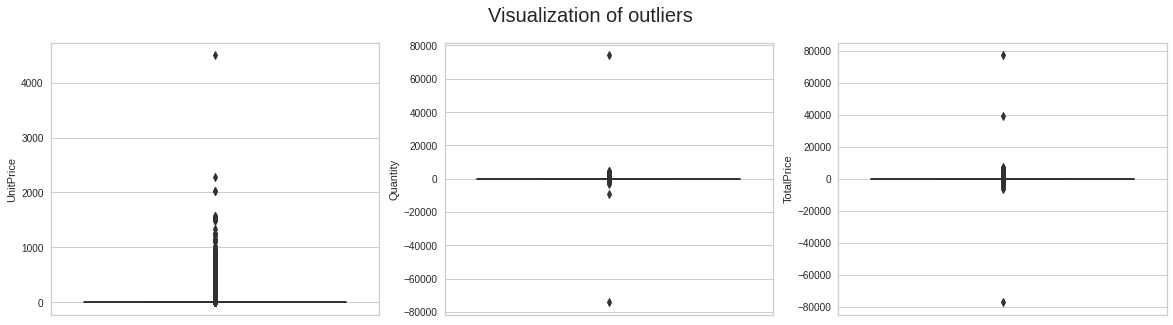

In [ ]:
df["TotalPrice"] = df["Quantity"]*df["UnitPrice"]

fig = plt.figure(figsize = (20,5))
fig.suptitle("Visualization of outliers",size=20)

axes = fig.add_subplot(1, 3, 1)
sns.boxplot(data=df,y="UnitPrice")

axes = fig.add_subplot(1, 3, 2)
sns.boxplot(data=df,y="Quantity")

axes = fig.add_subplot(1, 3, 3)
sns.boxplot(data=df,y="TotalPrice")


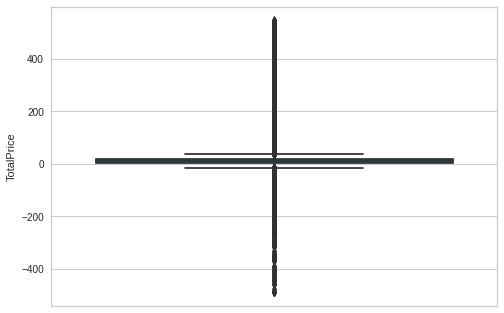

In [ ]:
df = df[(np.abs(stats.zscore(df[["TotalPrice"]])) < 3).all(axis=1)]
sns.boxplot(data=df,y="TotalPrice")

# Phân tích khám phá dữ liệu (EDA)

Xu hướng bán hàng chung là gì? Để nắm rõ được xu hướng, nhóm tiến hành lập biểu đồ số tiền được tạo ra bởi doanh số bán hàng ở mỗi ngày trong khoảng thời gian nghiên cứu:



In [ ]:
general_trend = pd.DataFrame(data={'Date':pd.to_datetime(df.InvoiceDate).dt.date,
                                  'Total price':df.Quantity*df.UnitPrice})
general_trend = general_trend.groupby("Date")["Total price"].sum()
general_trend = pd.DataFrame(general_trend)
general_trend

,Total price
Date,
2010-12-01,58635.56
2010-12-02,46207.28
2010-12-03,45620.46
2010-12-05,31383.95
2010-12-06,53860.18
...,...
2011-12-05,57751.32
2011-12-06,54228.37
2011-12-07,75076.22


In [ ]:
dates = []
dates.append(pd.to_datetime("201012",format="%Y%m"))
dates += [pd.to_datetime("2011"+str(month),format="%Y%m") for month in range(1,12)]
dates

[Timestamp('2010-12-01 00:00:00'),
 Timestamp('2011-01-01 00:00:00'),
 Timestamp('2011-02-01 00:00:00'),
 Timestamp('2011-03-01 00:00:00'),
 Timestamp('2011-04-01 00:00:00'),
 Timestamp('2011-05-01 00:00:00'),
 Timestamp('2011-06-01 00:00:00'),
 Timestamp('2011-07-01 00:00:00'),
 Timestamp('2011-08-01 00:00:00'),
 Timestamp('2011-09-01 00:00:00'),
 Timestamp('2011-10-01 00:00:00'),
 Timestamp('2011-11-01 00:00:00')]

In [ ]:
rolling_days = general_trend.copy()
rolling_days["Total price"] = rolling_days["Total price"].rolling(window=30).mean()
rolling_days

,Total price
Date,
2010-12-01,NaN
2010-12-02,NaN
2010-12-03,NaN
2010-12-05,NaN
2010-12-06,NaN
...,...
2011-12-05,55085.678667
2011-12-06,55935.239333
2011-12-07,56929.811333


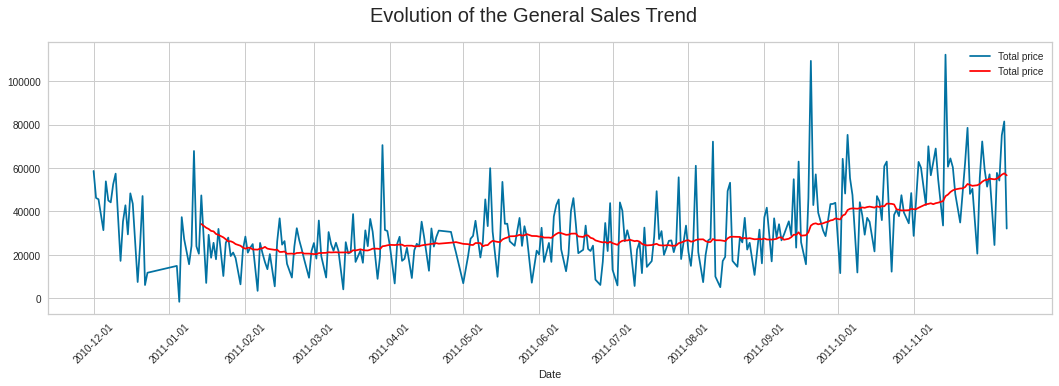

In [ ]:
plt.figure(figsize = (18,5)).suptitle('Evolution of the General Sales Trend', fontsize=20)
sns.lineplot(data=general_trend)
sns.lineplot(data=rolling_days, palette=['red'])
plt.xticks(dates,rotation = 45)
plt.show()

In [ ]:
general_trend.index = pd.to_datetime(general_trend.index)
general_trend_months = general_trend.groupby([general_trend.index.year,general_trend.index.month])['Total price'].sum()
general_trend_months = pd.DataFrame(general_trend_months)

In [ ]:
general_trend_months


,Total price
Date,
1,560000.260
2,498062.650
3,683267.080
4,493207.121
5,723333.510
6,691123.120
7,681300.111
8,682680.510
9,1019687.622


In [ ]:
general_trend_months["Date"] = dates


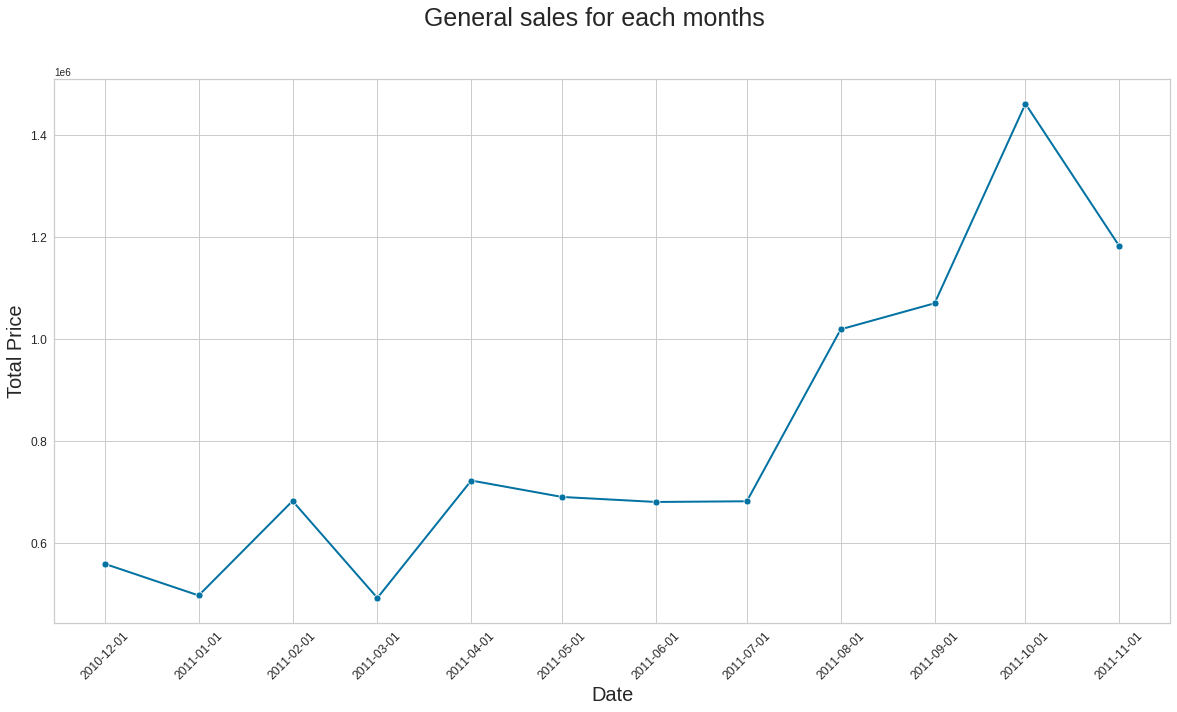

In [ ]:
plt.figure(figsize = (20,10)).suptitle('General sales for each months', fontsize=25)
lineplot = sns.lineplot(data=general_trend_months,x="Date", y="Total price", marker="o",linewidth = 2)

lineplot.set_xlabel(xlabel="Date",size = 20)
lineplot.set_ylabel(ylabel="Total Price",size = 20)
plt.yticks(fontsize=12)
plt.xticks(dates,rotation = 45,fontsize=12)

plt.show()

In [ ]:
df.Description.value_counts()[:10]


white hanging heart t-light holder    2284
regency cakestand 3 tier              2097
jumbo bag red retrospot               2089
party bunting                         1671
lunch bag red retrospot               1595
assorted colour bird ornament         1451
set of 3 cake tins pantry design      1421
small popcorn holder                  1396
pack of 72 retrospot cake cases       1347
lunch bag suki  design                1314
Name: Description, dtype: int64

Sản phẩm bán chạy nhất là "white hanging heart T-light holder". Mỗi quốc gia sẽ có sản phẩm bán chạy nhất khác nhau

Chúng ta có thể tính toán mức giao dịch trung bình hằng tháng của mỗi
khách hàng trên phạm vi toàn cầu:

In [ ]:
count_transactions_per_country = df.groupby([df.Country,df.InvoiceDate]).Description.count().reset_index()
count_transactions_per_country = count_transactions_per_country.groupby([count_transactions_per_country.Country]).Description.sum()
count_transactions_per_country = pd.DataFrame(count_transactions_per_country)
unique_per_country = df.groupby([df.Country]).CustomerID.nunique()
unique_per_country = pd.DataFrame(unique_per_country)

transactions_per_customer_per_countries = pd.concat([count_transactions_per_country,unique_per_country],axis=1).reset_index()
transactions_per_customer_per_countries["Value"] = transactions_per_customer_per_countries["Description"]/transactions_per_customer_per_countries["CustomerID"]/12

transactions_per_customer_per_countries.Description.sum()/transactions_per_customer_per_countries.CustomerID.sum()/12

9.851611908067254

Quốc gia có số lượng chi tiêu nhiều nhất?


In [ ]:
general_trend_country = pd.DataFrame(data={'Date':pd.to_datetime(df.InvoiceDate),
                                   'Country':df.Country,
                                  'Total price':df.Quantity*df.UnitPrice})
general_trend_country = general_trend_country.groupby([general_trend_country.Date.dt.to_period("M"),general_trend_country.Country]).sum()
general_trend_country = pd.DataFrame(general_trend_country).reset_index()
general_trend_country

,Date,Country,Total price
0,2010-12,Australia,1005.10
1,2010-12,Austria,137.04
2,2010-12,Bahrain,205.74
3,2010-12,Belgium,1599.91
4,2010-12,Channel Islands,363.53
...,...,...,...
285,2011-11,Spain,5459.87
286,2011-11,Sweden,2292.71
287,2011-11,Switzerland,7916.96
288,2011-11,United Kingdom,1140090.39


In [ ]:
general_trend_country.groupby([general_trend_country.Country]).sum().sort_values(by='Total price',ascending=False).head(10)


,Total price
Country,
United Kingdom,7207219.683
Netherlands,247908.660
EIRE,233058.520
Germany,191850.500
France,173482.940
Australia,114202.640
Switzerland,52505.350
Spain,43950.970
Belgium,35382.530


In [ ]:
number_customers = df.groupby(df["InvoiceDate"].dt.to_period('M'))["CustomerID"].nunique()
number_customers = pd.DataFrame(data=number_customers).reset_index()
number_customers["Date"] = number_customers.InvoiceDate.dt.to_timestamp()

number_new_customers = []
customers_seen = []
for month in df["InvoiceDate"].dt.to_period('M').unique():
    customers = df[df["InvoiceDate"].dt.to_period('M') == month].CustomerID.unique()
    count=0
    for customer in customers:
        if customer not in customers_seen:
            count+=1
            customers_seen.append(customer)
    number_new_customers.append((month,count))
number_new_customers = pd.DataFrame(number_new_customers,columns=["Date","New customers"])
number_new_customers.Date = number_new_customers.Date.dt.to_timestamp()
number_new_customers

,Date,New customers
0,2010-12-01,945
1,2011-01-01,418
2,2011-02-01,377
3,2011-03-01,442
4,2011-04-01,298
5,2011-05-01,279
6,2011-06-01,236
7,2011-07-01,188
8,2011-08-01,168
9,2011-09-01,300


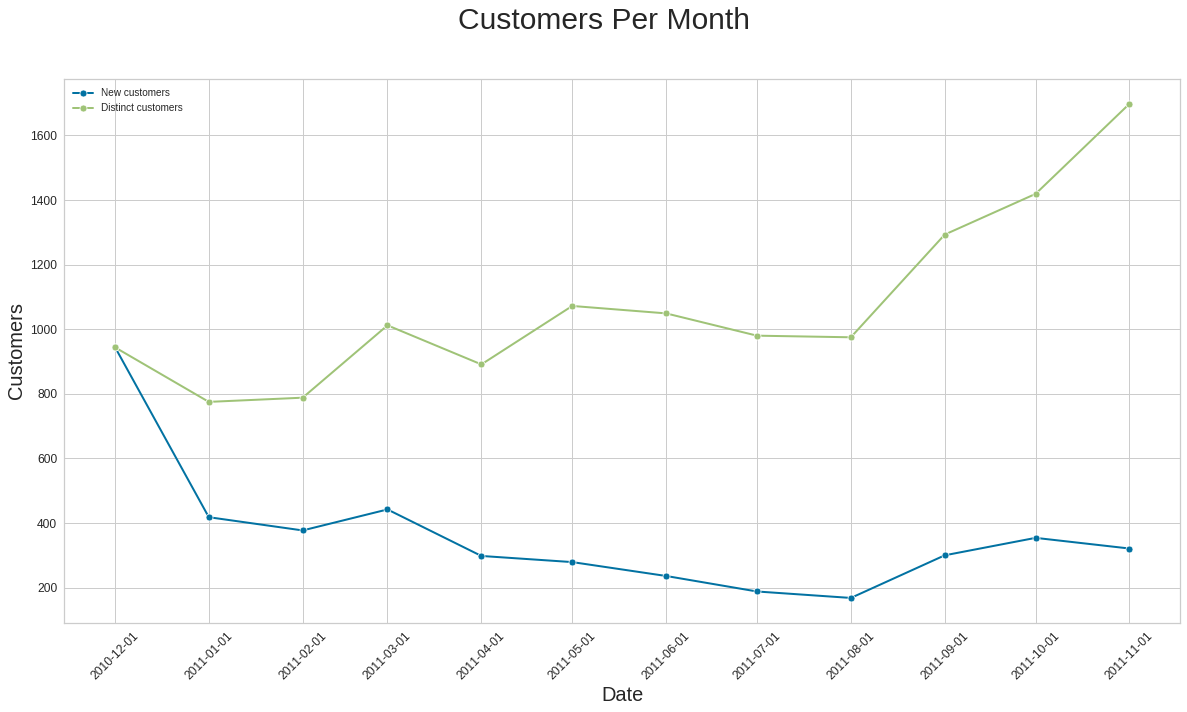

In [ ]:
fig  = plt.figure(figsize = (20,10)).suptitle('Customers Per Month', fontsize=30)
lineplot = sns.lineplot(data=number_new_customers,x="Date", y="New customers", marker="o",linewidth = 2, label="New customers")
sns.lineplot(data=number_customers,x="Date", y="CustomerID", marker="o",linewidth = 2, label="Distinct customers")

lineplot.set_xlabel("Date",fontsize=20)
lineplot.set_ylabel("Customers",fontsize=20)
plt.xticks(dates,rotation = 45,fontsize=12)
plt.yticks(fontsize=12)
plt.show()


Thời điểm nào khách hàng có xu hướng mua sản phẩm?



In [ ]:
df_temp = df.groupby([df.CustomerID,df.InvoiceDate]).Quantity.sum()
df_temp = pd.DataFrame(df_temp).reset_index()


In [ ]:
df_temp["Hour"]= df_temp["InvoiceDate"].dt.hour
df_temp["Month"]= df_temp["InvoiceDate"].dt.to_period('M')


In [ ]:
count_hours = pd.DataFrame(columns=range(1,25))
count_hours["Month"] = ""

for month in sorted(df_temp["Month"].unique()):
    row = []
    for hour in range(1,25):
        freq = len(df_temp[(df_temp["Month"]==month)&(df_temp["Hour"]==hour)])
        row.append(float(freq))
    row.append(month)
    count_hours.loc[len(count_hours)] = row

count_hours = count_hours.set_index("Month")


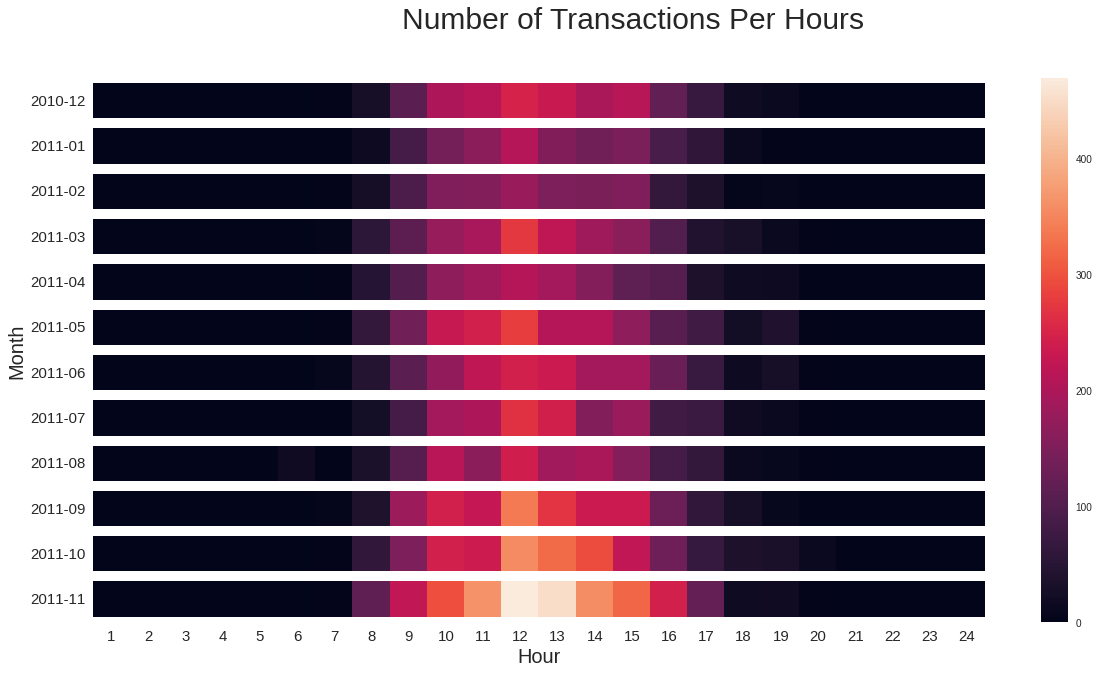

In [ ]:
fig  = plt.figure(figsize = (20,10)).suptitle('Number of Transactions Per Hours', fontsize=30)
heatmap = sns.heatmap(data=count_hours)
plt.yticks(rotation=0,size=15)
plt.xticks(size=15)
heatmap.set_xlabel("Hour",fontsize=20)
heatmap.set_ylabel("Month",fontsize=20)
for i in range(count_hours.shape[1] + 1):
    plt.axhline(i, color='white', lw=10)
plt.show()

In [ ]:
def daytime_encoder(date):
    if (date.hour >= 5)&(date.hour < 8):
        return "Early morning"
    elif (date.hour >= 8)&(date.hour < 11):
        return "Morning"
    elif (date.hour >= 11)&(date.hour < 13):
        return "Late morning"
    elif (date.hour >= 13)&(date.hour < 14):
        return "Early afternoon"
    elif (date.hour >= 14)&(date.hour < 15):
        return "Afternoon"
    elif (date.hour >= 15)&(date.hour < 17):
        return "Late afternoon"
    elif (date.hour >= 17)&(date.hour < 21):
        return "Evening"
    else:
        return date.hour
df_temp['InvoiceDate'] = df_temp['InvoiceDate'].map(daytime_encoder)


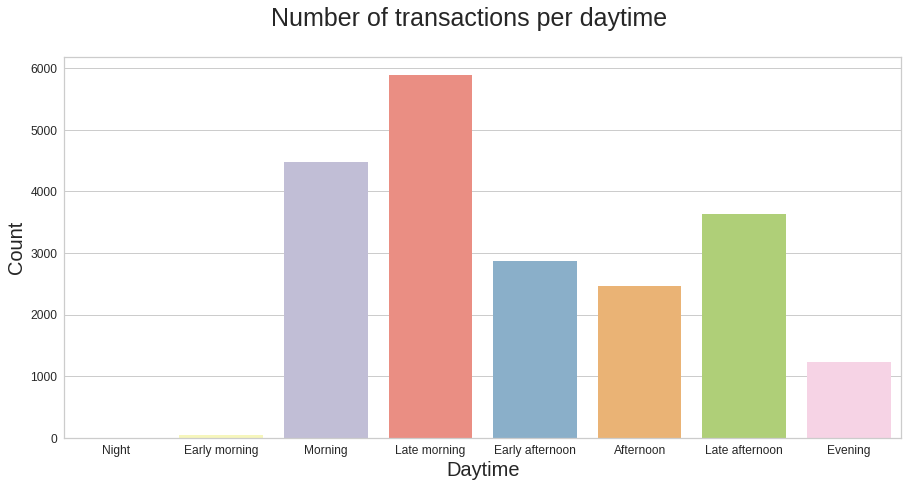

In [ ]:
fig  = plt.figure(figsize = (15,7)).suptitle('Number of transactions per daytime', fontsize=25)
countplot = sns.countplot(data=df_temp,x="InvoiceDate",order = ["Night","Early morning","Morning","Late morning","Early afternoon","Afternoon","Late afternoon","Evening"], palette="Set3")

countplot.set_xlabel("Daytime",fontsize=20)
countplot.set_ylabel("Count",fontsize=20)
plt.xticks(size=12)
plt.yticks(size=12)
plt.show()


Hầu hết các giao dịch được thực hiện vào cuối buổi sáng từ 11 giờ sáng đến 12 giờ sáng. Vào sáng sớm, từ 5 giờ sáng đến 8 giờ sáng không có nhiều giao dịch được thực hiện. Và vào ban đêm, không có bất kỳ giao dịch nào.


# Phân cụm K-means áp dụng vào phân khúc khách hàng

In [ ]:
today = pd.to_datetime('today').normalize()
df_clustering = df.groupby('CustomerID').agg({'InvoiceDate': lambda InvoiceDate: (today - InvoiceDate.max()).days,
                                     'InvoiceNo'    : 'nunique',
                                     'TotalPrice' : 'sum'})
df_clustering.columns = ['recency', 'frequency', 'monetary']
df_clustering

,recency,frequency,monetary
CustomerID,,,
12347.0,4021,6,4085.18
12348.0,4057,4,1437.24
12349.0,4000,1,1457.55
12350.0,4292,1,294.40
12352.0,4018,8,1265.41
...,...,...,...
18280.0,4259,1,180.60
18281.0,4162,1,80.82
18282.0,4104,2,98.76


In [ ]:
std_scaler = StandardScaler()
df_scaled = std_scaler.fit_transform(df_clustering)
df_scaled = pd.DataFrame(df_scaled,columns=['recency', 'frequency', 'monetary'])
df_scaled["CustomerID"] = df_clustering.index
df_scaled = df_scaled.set_index("CustomerID",drop=True)

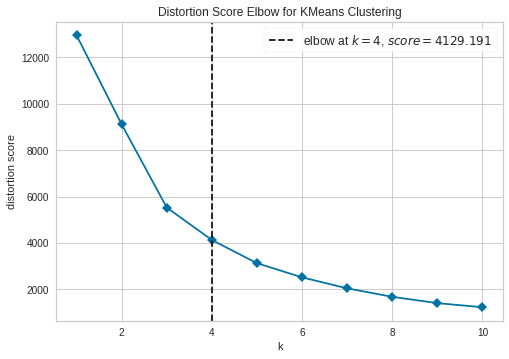

In [ ]:
model = KMeans()
visualizer = KElbowVisualizer(model, k=(1,11), timings= False)
visualizer.fit(df_scaled)
visualizer.show()

In [ ]:
kmeans = KMeans(n_clusters=4, n_init = 15, random_state=1)
kmeans.fit(df_scaled)
centroids = kmeans.cluster_centers_
centroid_df = pd.DataFrame(centroids, columns = list(df_scaled) )
centroid_df


,recency,frequency,monetary
0,-0.505254,-0.077718,-0.072624
1,1.510358,-0.346979,-0.209627
2,-0.861259,11.163562,14.164879
3,-0.781703,2.367451,1.406011


In [ ]:
df_labels = pd.DataFrame(kmeans.labels_ , columns = list(['labels']))
df_labels['labels'] = df_labels['labels'].astype('category')

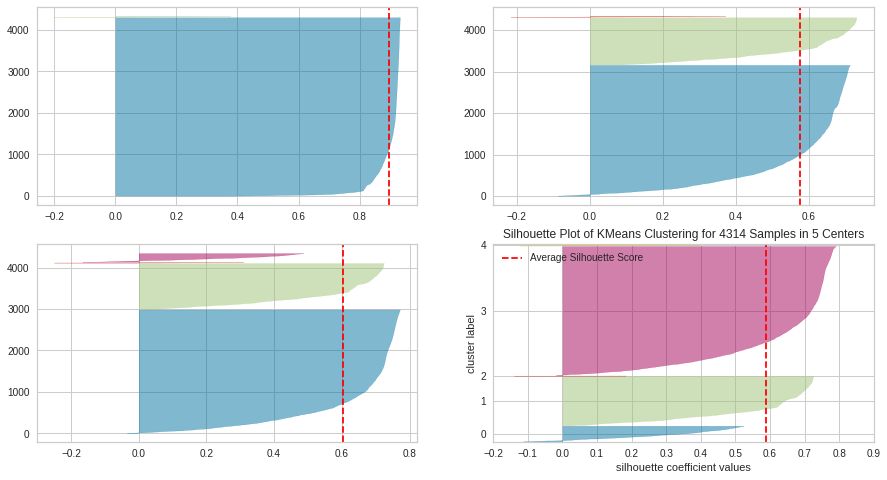

In [ ]:
#silhouette
from yellowbrick.cluster import SilhouetteVisualizer

fig, ax = plt.subplots(2, 2, figsize=(15,8))
for k in [2, 3, 4, 5]:

    km = KMeans(n_clusters=k, init='k-means++', n_init=10, max_iter=100, random_state=42)
    q, mod = divmod(k, 2)

    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod])
    visualizer.fit(df_scaled)

visualizer.show()


In [ ]:
df_kmeans = df_clustering.copy()
df_kmeans['labels'] = df_labels['labels'].values


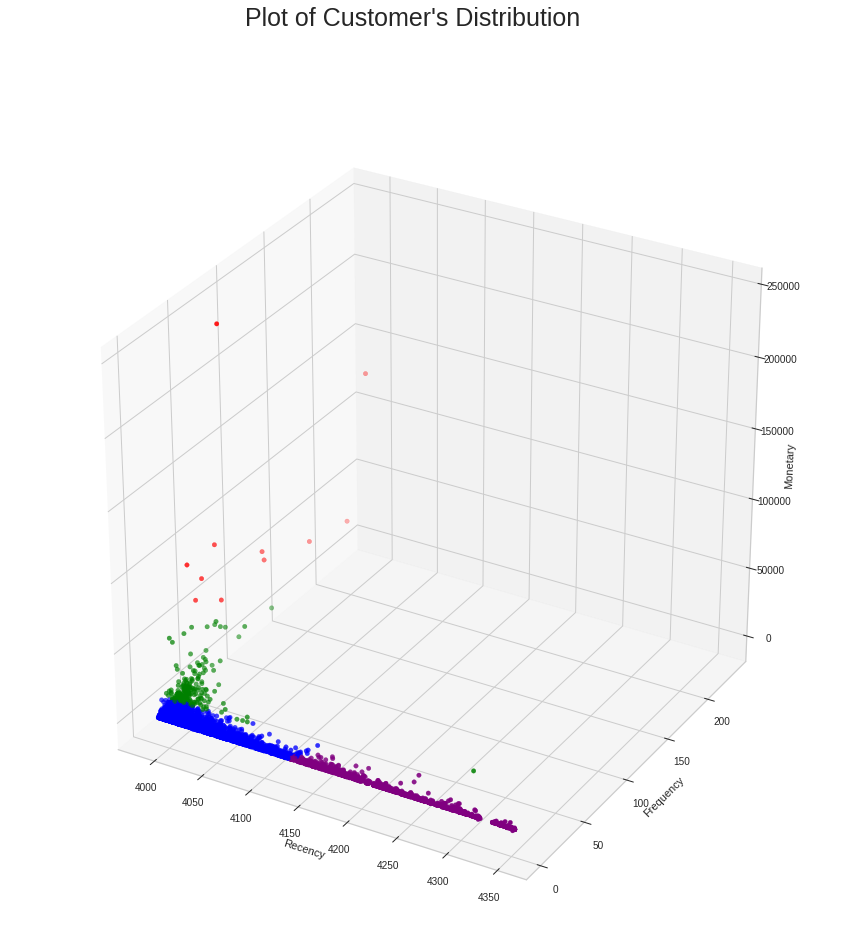

In [ ]:
colors = np.array(["blue", "purple","red","green"])
fig  = plt.figure(figsize = (15,15)).suptitle('Plot of Customer\'s Distribution', fontsize=25)
ax = plt.axes(projection='3d')
ax.scatter3D(df_kmeans["recency"], df_kmeans["frequency"], df_kmeans["monetary"], marker='o', c=colors[df_kmeans["labels"].tolist()])
ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary')
plt.legend()
plt.show()


In [ ]:
agg_list=["mean", "count", "max",]
df_kmeans[["labels", "recency", "frequency", "monetary"]].groupby("labels").agg(agg_list)


recency               frequency                 monetary        \
               mean count   max        mean count  max          mean count   
labels                                                                       
0       4028.140845  2982  4142    4.128102  2982   17   1234.838971  2982   
1       4228.643885  1112  4352    1.785971  1112   13    426.001314  1112   
2       3992.727273    11  4004  101.909091    11  232  85289.753636    11   
3       4000.641148   209  4281   25.397129   209  123   9964.353732   209   

                   
              max  
labels             
0        11056.93  
1         9338.38  
2       243207.14  
3        50415.49

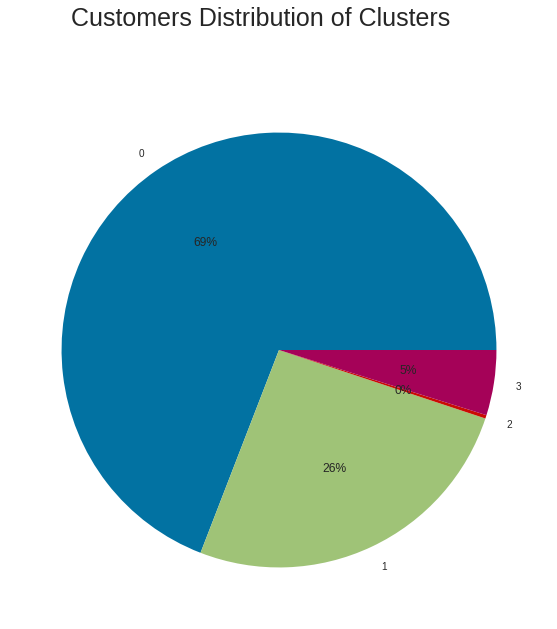

In [ ]:
df_kmeans = df_kmeans.reset_index()
clusters_count = df_kmeans.groupby("labels").agg({"CustomerID": "count"})
clusters_count.reset_index(inplace=True)
clusters_count.columns = ['cluster', 'count']

fig  = plt.figure(figsize = (20,10)).suptitle('Customers Distribution of Clusters', fontsize=25)
plt.pie(clusters_count["count"], labels = clusters_count["cluster"], autopct='%.0f%%')
plt.show()

Về việc phân khúc khách hàng, sau khi thực nghiệm với thuật toán K-means, nhóm đã sắp xếp khách hàng thành 4 nhóm khác nhau theo các hành vi khác nhau.
- Phân cụm 0: "Punctual customers" - những khách hàng mua các mặt hàng đúng giờ của doanh nghiệp.
- Phân cụm 1: "Hibernating customers" - những khách hàng mua với tần suất thấp nhất, gần đây nhất và chi tiêu ít tiền nhất.
- Phân cụm 2: "Exceptional customers" - những khách hàng mà công ty này muốn giữ chân, mua hàng với tần suất cao nhất, gần đây nhất và chi tiêu nhiều tiền nhất.
- Phân cụm 3: "Recent customers" - những khách hàng hoạt động khá tích cực gần đây có thể gây hứng thú để tiếp tục  kích thích nhu cầu mua hàng.